In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - triaxial_potential_DF.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Determine the origin of some strange features in the distribution function of the triaxial halo
'''

__author__ = "James Lane"

In [2]:
## Imports

## Basic
import numpy as np
import sys, os, pdb
import copy
import time

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
# from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib import colors
from matplotlib import cm
# import aplpy

## Astropy
# from astropy.io import fits
# from astropy.coordinates import SkyCoord
# from astropy import table
from astropy import units as apu
# from astropy import wcs

## galpy
from galpy import orbit
from galpy import potential
from galpy import df
from galpy.actionAngle import actionAngleAdiabatic
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv

## Add project-specific package. Assume relative location
sys.path.insert(0, os.path.abspath('../../src') )
import ast1501.potential

In [3]:
### Matplotlib
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Keywords

In [4]:
## Halo evolution
t_evolve = 10 # Gyr
tform = -9 # Gyr ago
tsteady = 8 # Gyr after formation

## Make the potential

In [6]:
## Get MWPotential2014 and construct the potential
pot_parms = ast1501.potential.get_MWPotential2014()
mwbulge_alpha, mwbulge_rc, mwbulge_amp, mwdisk_a, mwdisk_b, mwdisk_amp, mwhalo_a, mwhalo_amp = pot_parms

# Make the potentials
mwbulge = potential.PowerSphericalPotentialwCutoff(amp=mwbulge_amp, alpha=mwbulge_alpha, rc=mwbulge_rc)
mwbulge.turn_physical_off()
mwdisk = potential.MiyamotoNagaiPotential(amp=mwdisk_amp, a=mwdisk_a, b=mwdisk_b)
mwdisk.turn_physical_off()
mwhalo = potential.NFWPotential(amp=mwhalo_amp, a=mwhalo_a)
mwhalo.turn_physical_off()

# Make the negative amplitude NFW and wrap it
mwhalo_rev = potential.NFWPotential(amp=-1*mwhalo_amp,
                                    a=mwhalo_a)
mwhalo_rev_dsw = potential.DehnenSmoothWrapperPotential(pot=mwhalo_rev, tform=tform*apu.Gyr, 
                                                        tsteady=tsteady*apu.Gyr)
mwhalo_rev_dsw.turn_physical_off()

# Make MWPotential2014
mwpot = [mwhalo, mwdisk, mwbulge]

# Make the triaxial halo and wrap it
trihalo = potential.TriaxialNFWPotential(amp = mwhalo_amp, a = mwhalo_a, b = 2.0, pa = 0.0)
trihalo_dsw = potential.DehnenSmoothWrapperPotential(pot=trihalo, tform=tform*apu.Gyr, tsteady=tsteady*apu.Gyr)
trihalo_dsw.turn_physical_off()
    
# Make the triaxial potential
tripot_grow = [mwhalo, mwhalo_rev_dsw, trihalo_dsw, mwdisk, mwbulge]

# Try the new galpy decay behaviour for DSW
mwhalo_decay_dsw = mwhalo_rev_dsw = potential.DehnenSmoothWrapperPotential(pot=mwhalo, tform=tform*apu.Gyr, 
                                                        tsteady=tsteady*apu.Gyr, decay=True)
mwhalo_decay_dsw.turn_physical_off()
tripot_grow_dec = [mwhalo_decay_dsw, trihalo_dsw, mwdisk, mwbulge]

## Make the distribution function

In [177]:
## Make the quasi-isothermal distribution function. See notebook #3 for the velocity scales.

# Velocity dispersions in km/s
sigma_vR = 46/1.5
sigma_vT = 40/1.5
sigma_vZ = 28/1.5

# Action angle coordinates and the DF
qdf_aA= actionAngleAdiabatic(pot=potential.MWPotential2014, c=True)
qdf = df.quasiisothermaldf( hr= 2*apu.kpc,
                            sr= sigma_vR*(apu.km/apu.s),
                            sz= sigma_vZ*(apu.km/apu.s),
                            hsr= 9.8*(apu.kpc),
                            hsz= 7.6*(apu.kpc),
                            pot= potential.MWPotential2014, 
                            aA= qdf_aA)

# First check the distribution function in the outter halo

In [182]:
# Now make the grid for our velocities, which will span 2sigma (approx) in each of R,T,Z velocities
# Manually set ranges for clean dV
dvT = 10.
dvR = 10.

vR_low = -120
vR_hi = 120
vT_low = -100
vT_hi = 100

vR_low = -2*sigma_vR*1.5
vR_hi = 2*sigma_vR*1.5
vT_low = -2*sigma_vT*1.5
vT_hi = 2*sigma_vT*1.5

vR_range = np.arange( vR_low, vR_hi, dvR )
vT_range = np.arange( vT_low, vT_hi, dvT )+200 # Plus rotational velocity minus 10 for Assym. Drift.

# This goes along with a grid of distribution function values. The perturbed array will have one 
# dimension for the changing halo parameters. The unperturbed DF will not change, so only 2D
dfp = np.zeros((len(vR_range),len(vT_range)))
df0 = np.zeros((len(vR_range),len(vT_range)))

print( str(len(vR_range)*len(vT_range))+' independent velocities' )

304 independent velocities


In [183]:
## Now evaluate the distribution function

# The times over which each orbit will be integrated
times = -np.array([0,t_evolve]) * apu.Gyr

# Timing
ot_total = 0
oit_total = 0
dft_total = 0

tott_start = time.time()


# Loop over the velocities
for j in range( len(vR_range) ):
    for k in range( len(vT_range) ):

        # Make the orbit
        o = orbit.Orbit(vxvv=[16.*apu.kpc, 
                              vR_range[j]*apu.km/apu.s, 
                              vT_range[k]*apu.km/apu.s, 
                              0.2*apu.kpc,
                              0.*apu.km/apu.s,
                              0.*apu.radian])

        # Evaluate the unperturbed distribution function if this is the first run-through           
        df0[j,k] = qdf(o)

        oit_start = time.time()
        o.integrate(times, tripot_grow_dec)
        oit_end = time.time()

        # Now evaluate the perturbed distribution function
        dft_start = time.time()
        dfp[j,k] = qdf(o(times[-1]))
        dft_end = time.time()

        oit_total += (oit_end-oit_start)
        dft_total += (dft_end-dft_start)
        
        # Talk
        sys.stdout.write('\r')
        sys.stdout.write( 'Done '+str(j*len(vT_range)+k+1)+' of '+str(len(vT_range)*len(vR_range)) )
        sys.stdout.flush()
        
tott_end = time.time()

# Display timing statistics
print('\nTook '+str(round(tott_end-tott_start,2))+' s total')
print('Orbit integration took '+str(round(oit_total,2))+' s')
print('DF evaluation took '+str(round(dft_total,2))+' s')
print('Took '+str(round((tott_end-tott_start)/(len(vR_range)*len(vT_range)),2))+' s per velocity')

Done 304 of 304
Took 84.58 s total
Orbit integration took 82.45 s
DF evaluation took 0.64 s
Took 0.28 s per velocity


## Plotting
### First show the distribution function

In [180]:
print(dfp[4,3])
print(df0[4,3])
print(vR_range[4])
print(vT_range[3])

148.62002829311098
12.786104411034517
-21.333333333333336
176.66666666666666


277.1980394767735
263.5440675523767


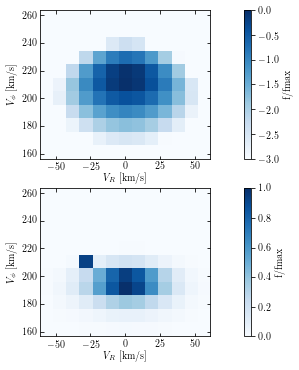

In [181]:
fig = plt.figure( figsize=(12,6) )
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

## Make the original distribution function
img_arr = np.rot90( df0/np.max(df0) )
print(np.max(df0))
img1 = ax1.imshow(np.log10(img_arr), interpolation='nearest',
                    extent=[vR_low, vR_hi, vT_low+210, vT_hi+210],
                    cmap='Blues', vmax=0, vmin=-3)

# Decorate
cbar1 = plt.colorbar(img1, ax=ax1)

# Adjust
ax1.set_ylabel(r'$V_{\phi}$ [km/s]')
cbar1.set_label('f/fmax')

ax1.tick_params(direction='in', top='on', right='on')
ax1.set_xlabel(r'$V_{R}$ [km/s]')


## Make the triaxial distribution function
img_arr = np.rot90( dfp/np.max(dfp) )
print(np.max(dfp))
img2 = ax2.imshow(img_arr, interpolation='nearest',
                    extent=[vR_low, vR_hi, vT_low+210, vT_hi+210],
                    cmap='Blues', vmax=1, vmin=0)

# Decorate
cbar2 = plt.colorbar(img2, ax=ax2)

# Adjust
ax2.set_ylabel(r'$V_{\phi}$ [km/s]')
cbar2.set_label('f/fmax')

ax2.tick_params(direction='in', top='on', right='on')
ax2.set_xlabel(r'$V_{R}$ [km/s]')

# fig.subplots_adjust(hspace=0)
plt.show()

### Summary of findings
- The exact spacing of the input grid is what determines whether you are going to get a strange output feature
- Changing z changes the location of the feature
- When z=0 the excess feature appears at vR=-72, vT=270
- When z=0.1 the excess feature appears at vR=-52 ,vT=250
- Increasing to z=0.2 removes all strange features

## We know strange features appear only under certain conditions so recreate around those conditions - First a halo orbit with no z

In [88]:
# Now manually make the grid around the problem area
dvT = 1.
dvR = 1.

vR_low = -75
vR_hi = -69
vT_low = 267
vT_hi = 273

vR_range = np.arange( vR_low, vR_hi, dvR )
vT_range = np.arange( vT_low, vT_hi, dvT )

# This goes along with a grid of distribution function values. The perturbed array will have one 
# dimension for the changing halo parameters. The unperturbed DF will not change, so only 2D
dfp = np.zeros((len(vR_range),len(vT_range)))
df0 = np.zeros((len(vR_range),len(vT_range)))

print( str(len(vR_range)*len(vT_range))+' independent velocities' )

36 independent velocities


Done 35 of 36

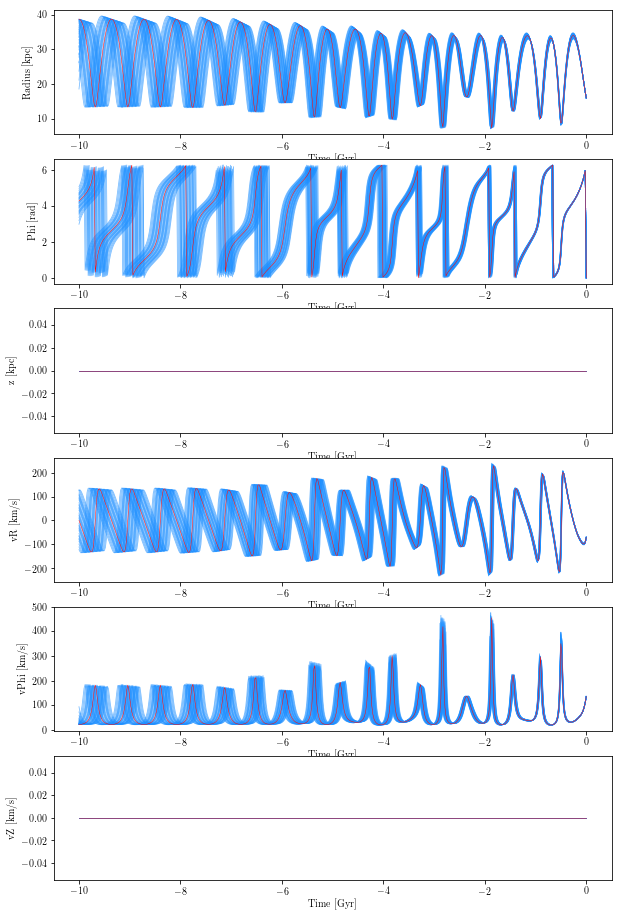

In [107]:
## Now evaluate the distribution function but focus on the problem area

# The times over which each orbit will be integrated
times = -np.linspace(0,t_evolve,num=500) * apu.Gyr

# Make a figure
fig = plt.figure( figsize=(10,16) )
ax1 = fig.add_subplot(611)
ax2 = fig.add_subplot(612)
ax3 = fig.add_subplot(613)
ax4 = fig.add_subplot(614)
ax5 = fig.add_subplot(615)
ax6 = fig.add_subplot(616)

# Loop over the velocities
for j in range( len(vR_range) ):
    for k in range( len(vT_range) ):

        # Make the orbit
        o = orbit.Orbit(vxvv=[16.*apu.kpc, 
                              vR_range[j]*apu.km/apu.s, 
                              vT_range[k]*apu.km/apu.s, 
                              0.*apu.kpc,
                              0.*apu.km/apu.s,
                              0.*apu.radian])

        # Evaluate the unperturbed distribution function if this is the first run-through           
        df0[j,k] = qdf(o)

        o.integrate(times, tripot_grow_dec)

        # Now evaluate the perturbed distribution function
        dfp[j,k] = qdf(o(times[-1]))
        
        if vR_range[j] == -72 and vT_range[k] == 270:
            ax1.plot( times.value, o.R(times).value, color='Red', alpha=1.0, zorder=10, linewidth=0.5)
            ax2.plot( times.value, o.phi(times), color='Red', alpha=1.0, zorder=10, linewidth=0.5)
            ax3.plot( times.value, o.z(times), color='Red', alpha=1.0, zorder=10, linewidth=0.5)
            ax4.plot( times.value, o.vR(times), color='Red', alpha=1.0, zorder=10, linewidth=0.5)
            ax5.plot( times.value, o.vphi(times), color='Red', alpha=1.0, zorder=10, linewidth=0.5)
            ax6.plot( times.value, o.vz(times), color='Red', alpha=1.0, zorder=10, linewidth=0.5)
        else:
            ax1.plot( times.value, o.R(times).value, color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
            ax2.plot( times.value, o.phi(times), color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
            ax3.plot( times.value, o.z(times), color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
            ax4.plot( times.value, o.vR(times), color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
            ax5.plot( times.value, o.vphi(times), color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
            ax6.plot( times.value, o.vz(times), color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
        ##fi
        
        # Talk
        sys.stdout.write('\r')
        sys.stdout.write( 'Done '+str(j*len(vT_range)+k)+' of '+str(len(vT_range)*len(vR_range)) )
        sys.stdout.flush()
    ###k
###j

ax1.set_xlabel('Time [Gyr]')
ax1.set_ylabel('Radius [kpc]')

ax2.set_xlabel('Time [Gyr]')
ax2.set_ylabel('Phi [rad]')

ax3.set_xlabel('Time [Gyr]')
ax3.set_ylabel('z [kpc]')

ax4.set_xlabel('Time [Gyr]')
ax4.set_ylabel('vR [km/s]')

ax5.set_xlabel('Time [Gyr]')
ax5.set_ylabel('vPhi [km/s]')

ax6.set_xlabel('Time [Gyr]')
ax6.set_ylabel('vZ [km/s]')

plt.savefig('test1.pdf',dpi=500)
plt.show()

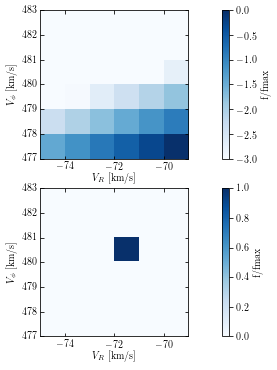

In [90]:
fig = plt.figure( figsize=(12,6) )
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

## Make the original distribution function
img_arr = np.rot90( df0/np.max(df0) )
img1 = ax1.imshow(np.log10(img_arr), interpolation='nearest',
                    extent=[vR_low, vR_hi, vT_low+210, vT_hi+210],
                    cmap='Blues', vmax=0, vmin=-3)

# Decorate
cbar1 = plt.colorbar(img1, ax=ax1)

# Adjust
ax1.set_ylabel(r'$V_{\phi}$ [km/s]')
cbar1.set_label('f/fmax')

ax1.tick_params(direction='in', top='on', right='on')
ax1.set_xlabel(r'$V_{R}$ [km/s]')


## Make the triaxial distribution function
img_arr = np.rot90( dfp/np.max(dfp) )
img2 = ax2.imshow(img_arr, interpolation='nearest',
                    extent=[vR_low, vR_hi, vT_low+210, vT_hi+210],
                    cmap='Blues', vmax=1, vmin=0)

# Decorate
cbar2 = plt.colorbar(img2, ax=ax2)

# Adjust
ax2.set_ylabel(r'$V_{\phi}$ [km/s]')
cbar2.set_label('f/fmax')

ax2.tick_params(direction='in', top='on', right='on')
ax2.set_xlabel(r'$V_{R}$ [km/s]')

# fig.subplots_adjust(hspace=0)
plt.show()

## Now try an orbit with 0.1 z. The feature appears at a different location now

In [170]:
# Now manually make the grid around the problem area
dvT = 1.
dvR = 1.

vR_low = -55.0
vR_hi = -50.0
vT_low = 148.0
vT_hi = 153.0

vR_range = np.arange( vR_low, vR_hi, dvR )
vT_range = np.arange( vT_low, vT_hi, dvT )

# This goes along with a grid of distribution function values. The perturbed array will have one 
# dimension for the changing halo parameters. The unperturbed DF will not change, so only 2D
dfp = np.zeros((len(vR_range),len(vT_range)))
df0 = np.zeros((len(vR_range),len(vT_range)))

print( str(len(vR_range)*len(vT_range))+' independent velocities' )

print(vT_range)
print(vR_range)

25 independent velocities
[148. 149. 150. 151. 152.]
[-55. -54. -53. -52. -51.]


[3.75836238]
Done 0 of 25[3.98130485]
Done 1 of 25[4.21517482]
Done 2 of 25[4.47013375]
Done 3 of 25[4.72645789]
Done 4 of 25[3.94787782]
Done 5 of 25[4.17788359]
Done 6 of 25[4.43643444]
Done 7 of 25[4.69197061]
Done 8 of 25[4.97876709]
Done 9 of 25[4.13462117]
Done 10 of 25[4.3770691]
Done 11 of 25[4.65577467]
Done 12 of 25[4.92286604]
Done 13 of 25[5.24109164]
Done 14 of 25[4.32107235]
Done 15 of 25[4.58825262]
Done 16 of 25> <ipython-input-171-60e245bc085a>(21)<module>()
-> o = orbit.Orbit(vxvv=[16.*apu.kpc,
(Pdb) c
[111.21488455]
Done 17 of 25[5.17072221]
Done 18 of 25[5.50748462]
Done 19 of 25[4.51432441]
Done 20 of 25[4.81167712]
Done 21 of 25[5.11244701]
Done 22 of 25[5.43156832]
Done 23 of 25[5.7731978]
Done 24 of 25

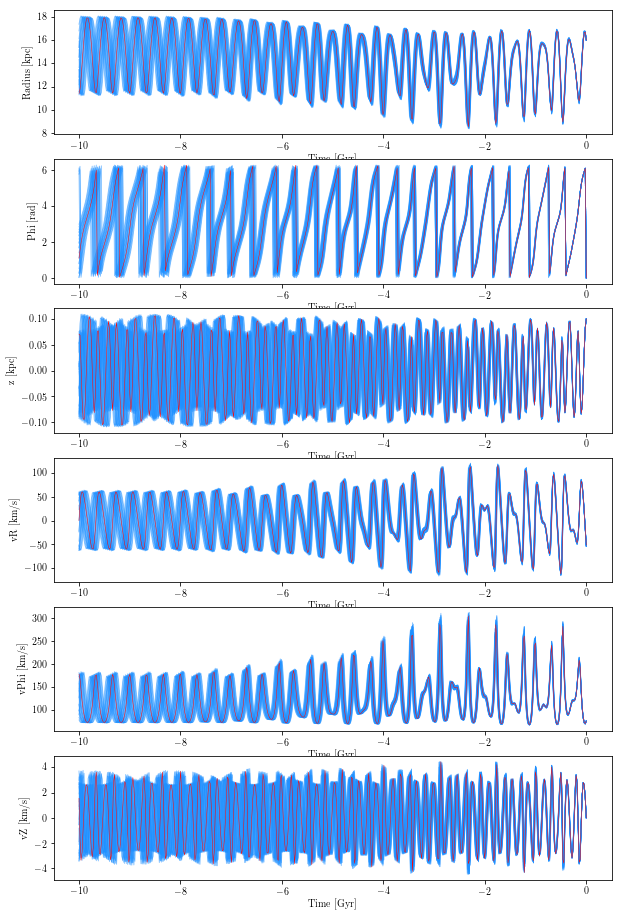

In [171]:
## Now evaluate the distribution function but focus on the problem area
 
# The times over which each orbit will be integrated
times = -np.linspace(0,t_evolve,num=500) * apu.Gyr

# Make a figure
fig = plt.figure( figsize=(10,16) )
ax1 = fig.add_subplot(611)
ax2 = fig.add_subplot(612)
ax3 = fig.add_subplot(613)
ax4 = fig.add_subplot(614)
ax5 = fig.add_subplot(615)
ax6 = fig.add_subplot(616)

# Loop over the velocities
for j in range( len(vR_range) ):
    for k in range( len(vT_range) ):

        # Make the orbit
        o = orbit.Orbit(vxvv=[16.*apu.kpc, 
                              vR_range[j]*apu.km/apu.s, 
                              vT_range[k]*apu.km/apu.s, 
                              0.1*apu.kpc,
                              0.*apu.km/apu.s,
                              0.*apu.radian])

        # Evaluate the unperturbed distribution function if this is the first run-through           
        df0[j,k] = qdf(o)

        o.integrate(times, tripot_grow_dec)

        # Now evaluate the perturbed distribution function
        dfp[j,k] = qdf(o(times[-1]))
        
        if vR_range[j] == -52 and vT_range[k] == 150:
            ax1.plot( times.value, o.R(times).value, color='Red', alpha=1.0, zorder=10, linewidth=0.5)
            ax2.plot( times.value, o.phi(times), color='Red', alpha=1.0, zorder=10, linewidth=0.5)
            ax3.plot( times.value, o.z(times), color='Red', alpha=1.0, zorder=10, linewidth=0.5)
            ax4.plot( times.value, o.vR(times), color='Red', alpha=1.0, zorder=10, linewidth=0.5)
            ax5.plot( times.value, o.vphi(times), color='Red', alpha=1.0, zorder=10, linewidth=0.5)
            ax6.plot( times.value, o.vz(times), color='Red', alpha=1.0, zorder=10, linewidth=0.5)
        else:
            ax1.plot( times.value, o.R(times).value, color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
            ax2.plot( times.value, o.phi(times), color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
            ax3.plot( times.value, o.z(times), color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
            ax4.plot( times.value, o.vR(times), color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
            ax5.plot( times.value, o.vphi(times), color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
            ax6.plot( times.value, o.vz(times), color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
        ##fi
        
        # Talk
        sys.stdout.write('\r')
        sys.stdout.write( 'Done '+str(j*len(vT_range)+k)+' of '+str(len(vT_range)*len(vR_range)) )
        sys.stdout.flush()
    ###k
###j

ax1.set_xlabel('Time [Gyr]')
ax1.set_ylabel('Radius [kpc]')

ax2.set_xlabel('Time [Gyr]')
ax2.set_ylabel('Phi [rad]')

ax3.set_xlabel('Time [Gyr]')
ax3.set_ylabel('z [kpc]')

ax4.set_xlabel('Time [Gyr]')
ax4.set_ylabel('vR [km/s]')

ax5.set_xlabel('Time [Gyr]')
ax5.set_ylabel('vPhi [km/s]')

ax6.set_xlabel('Time [Gyr]')
ax6.set_ylabel('vZ [km/s]')

plt.savefig('test2.pdf',dpi=500)
plt.show()

1.3324513124450952
111.21488454688702


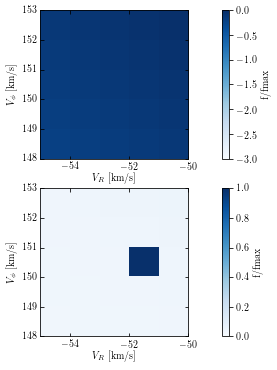

In [172]:
fig = plt.figure( figsize=(12,6) )
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

## Make the original distribution function
img_arr = np.rot90( df0/np.max(df0) )
print(np.amax(df0))
img1 = ax1.imshow(np.log10(img_arr), interpolation='nearest',
                    extent=[vR_low, vR_hi, vT_low, vT_hi],
                    cmap='Blues', vmax=0, vmin=-3)

# Decorate
cbar1 = plt.colorbar(img1, ax=ax1)

# Adjust
ax1.set_ylabel(r'$V_{\phi}$ [km/s]')
cbar1.set_label('f/fmax')

ax1.tick_params(direction='in', top='on', right='on')
ax1.set_xlabel(r'$V_{R}$ [km/s]')


## Make the triaxial distribution function
img_arr = np.rot90( dfp/np.max(dfp) )
print(np.amax(dfp))
img2 = ax2.imshow(img_arr, interpolation='nearest',
                    extent=[vR_low, vR_hi, vT_low, vT_hi],
                    cmap='Blues', vmax=1, vmin=0)

# Decorate
cbar2 = plt.colorbar(img2, ax=ax2)

# Adjust
ax2.set_ylabel(r'$V_{\phi}$ [km/s]')
cbar2.set_label('f/fmax')

ax2.tick_params(direction='in', top='on', right='on')
ax2.set_xlabel(r'$V_{R}$ [km/s]')

# fig.subplots_adjust(hspace=0)
plt.show()

## Now try the phi potential that has one of these wierd features

In [189]:
## Make the new potential

phi = np.linspace(0, np.pi/2, 5)[3]

# Make the triaxial halo and wrap it
trihalo = potential.TriaxialNFWPotential(amp = mwhalo_amp, a = mwhalo_a, b = 2.0, pa = phi)
trihalo_dsw = potential.DehnenSmoothWrapperPotential(pot=trihalo, tform=tform*apu.Gyr, tsteady=tsteady*apu.Gyr)
trihalo_dsw.turn_physical_off()
    
# Make the triaxial potential
tripot_grow = [mwhalo, mwhalo_rev_dsw, trihalo_dsw, mwdisk, mwbulge]

# Try the new galpy decay behaviour for DSW
mwhalo_decay_dsw = mwhalo_rev_dsw = potential.DehnenSmoothWrapperPotential(pot=mwhalo, tform=tform*apu.Gyr, 
                                                        tsteady=tsteady*apu.Gyr, decay=True)
mwhalo_decay_dsw.turn_physical_off()
tripot_grow_dec = [mwhalo_decay_dsw, trihalo_dsw, mwdisk, mwbulge]

In [203]:
# Now manually make the grid around the problem area
dvT = 10.
dvR = 10.

vR_low = 0
vR_hi = 50
vT_low = 180
vT_hi = 

vR_range = np.arange( vR_low, vR_hi, dvR )
vT_range = np.arange( vT_low, vT_hi, dvT )

# This goes along with a grid of distribution function values. The perturbed array will have one 
# dimension for the changing halo parameters. The unperturbed DF will not change, so only 2D
dfp = np.zeros((len(vR_range),len(vT_range)))
df0 = np.zeros((len(vR_range),len(vT_range)))

print( str(len(vR_range)*len(vT_range))+' independent velocities' )

print(vT_range)
print(vR_range)

25 independent velocities
[230. 240. 250. 260. 270.]
[ 0. 10. 20. 30. 40.]


Done 16 of 25258.16917149599504
Done 24 of 25

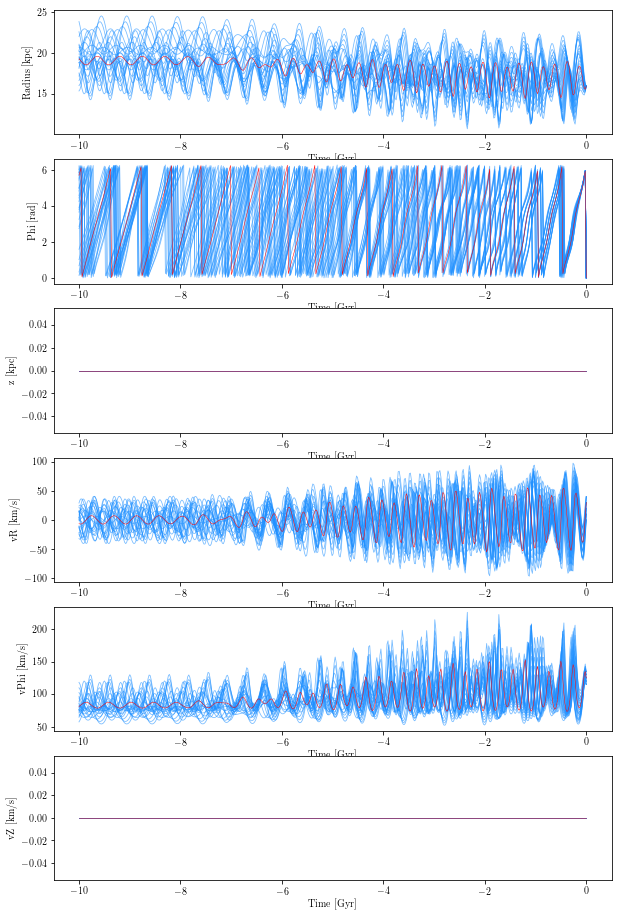

In [211]:
## Now evaluate the distribution function but focus on the problem area
 
# The times over which each orbit will be integrated
times = -np.linspace(0,t_evolve,num=500) * apu.Gyr

# Make a figure
fig = plt.figure( figsize=(10,16) )
ax1 = fig.add_subplot(611)
ax2 = fig.add_subplot(612)
ax3 = fig.add_subplot(613)
ax4 = fig.add_subplot(614)
ax5 = fig.add_subplot(615)
ax6 = fig.add_subplot(616)

# Loop over the velocities
for j in range( len(vR_range) ):
    for k in range( len(vT_range) ):

        # Make the orbit
        o = orbit.Orbit(vxvv=[16.*apu.kpc, 
                              vR_range[j]*apu.km/apu.s, 
                              vT_range[k]*apu.km/apu.s, 
                              0.*apu.kpc,
                              0.*apu.km/apu.s,
                              0.*apu.radian])

        # Evaluate the unperturbed distribution function if this is the first run-through           
        df0[j,k] = qdf(o)

        o.integrate(times, tripot_grow_dec)

        # Now evaluate the perturbed distribution function
        dfp[j,k] = qdf(o(times[-1]))
        
        if vR_range[j] == 30 and vT_range[k] == 250:
            print(dfp[j,k])
            ax1.plot( times.value, o.R(times).value, color='Red', alpha=1.0, zorder=10, linewidth=0.5)
            ax2.plot( times.value, o.phi(times), color='Red', alpha=1.0, zorder=10, linewidth=0.5)
            ax3.plot( times.value, o.z(times), color='Red', alpha=1.0, zorder=10, linewidth=0.5)
            ax4.plot( times.value, o.vR(times), color='Red', alpha=1.0, zorder=10, linewidth=0.5)
            ax5.plot( times.value, o.vphi(times), color='Red', alpha=1.0, zorder=10, linewidth=0.5)
            ax6.plot( times.value, o.vz(times), color='Red', alpha=1.0, zorder=10, linewidth=0.5)
        else:
            ax1.plot( times.value, o.R(times).value, color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
            ax2.plot( times.value, o.phi(times), color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
            ax3.plot( times.value, o.z(times), color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
            ax4.plot( times.value, o.vR(times), color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
            ax5.plot( times.value, o.vphi(times), color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
            ax6.plot( times.value, o.vz(times), color='DodgerBlue', alpha=0.6, zorder=1, linewidth=0.8)
        ##fi
        
        # Talk
        sys.stdout.write('\r')
        sys.stdout.write( 'Done '+str(j*len(vT_range)+k)+' of '+str(len(vT_range)*len(vR_range)) )
        sys.stdout.flush()
    ###k
###j

ax1.set_xlabel('Time [Gyr]')
ax1.set_ylabel('Radius [kpc]')

ax2.set_xlabel('Time [Gyr]')
ax2.set_ylabel('Phi [rad]')

ax3.set_xlabel('Time [Gyr]')
ax3.set_ylabel('z [kpc]')

ax4.set_xlabel('Time [Gyr]')
ax4.set_ylabel('vR [km/s]')

ax5.set_xlabel('Time [Gyr]')
ax5.set_ylabel('vPhi [km/s]')

ax6.set_xlabel('Time [Gyr]')
ax6.set_ylabel('vZ [km/s]')

plt.savefig('test2.pdf',dpi=500)
plt.show()

0.3137047710170138
258.16917149599504


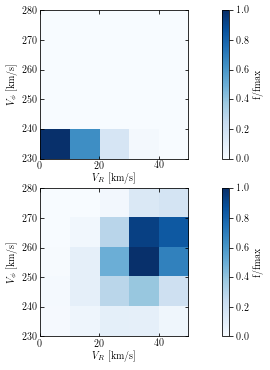

In [212]:
fig = plt.figure( figsize=(12,6) )
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

## Make the original distribution function
img_arr = np.rot90( df0/np.max(df0) )
print(np.amax(df0))
img1 = ax1.imshow(img_arr, interpolation='nearest',
                    extent=[vR_low, vR_hi, vT_low, vT_hi],
                    cmap='Blues', vmax=1, vmin=0)

# Decorate
cbar1 = plt.colorbar(img1, ax=ax1)

# Adjust
ax1.set_ylabel(r'$V_{\phi}$ [km/s]')
cbar1.set_label('f/fmax')

ax1.tick_params(direction='in', top='on', right='on')
ax1.set_xlabel(r'$V_{R}$ [km/s]')


## Make the triaxial distribution function
img_arr = np.rot90( dfp/np.max(dfp) )
print(np.amax(dfp))
img2 = ax2.imshow(img_arr, interpolation='nearest',
                    extent=[vR_low, vR_hi, vT_low, vT_hi],
                    cmap='Blues', vmax=1, vmin=0)

# Decorate
cbar2 = plt.colorbar(img2, ax=ax2)

# Adjust
ax2.set_ylabel(r'$V_{\phi}$ [km/s]')
cbar2.set_label('f/fmax')

ax2.tick_params(direction='in', top='on', right='on')
ax2.set_xlabel(r'$V_{R}$ [km/s]')

# fig.subplots_adjust(hspace=0)
plt.show()